Last year I was the TA for [Aaron Shaw](http://aaronshaw.org)'s [introductory stats class](https://wiki.communitydata.science/Statistics_and_Statistical_Programming_(Spring_2019)).

As we talked about ANOVAs, I realized that I didn't totally understand what was going on "under the hood". So, I played around with some simulated data in R to help myself to understand it. I'm sharing it in the hopes that someone else will benefit also.

First, we create simulated data - ANOVA assumes that the data from each group are normal, with equal variance, so we simulate normal distributions with three different means but the same variance. ANOVA should tell us that they are different.

In [157]:
library(tidyverse)

df = data.frame(grp = c(rep('grp1', 100), 
                        rep('grp2', 150),
                       rep('grp3', 50)),
                val=c(rnorm(n = 100,
                            mean = 0,
                            sd = 1
                           ),
                      rnorm(n = 150,
                            mean = 1,
                            sd = 1
                           ),
                     rnorm(n = 50,
                           mean = 2,
                           sd = 1
                )))
theme_set(theme_minimal())

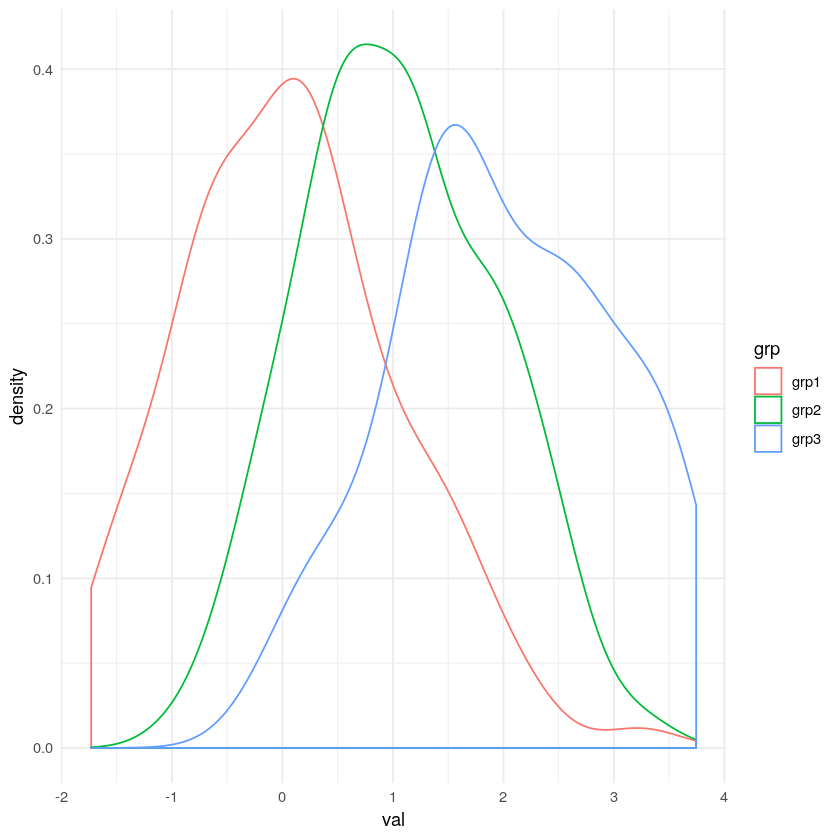

In [158]:
df %>% ggplot(aes(x=val)) + geom_density(aes(color=grp))

The main idea behind ANOVA is comparing how far group means are from the total mean to how far individual observations are from their group's mean. The key intuition is that if there is a lot of variation between observations, then in order to be confident that the groups are actually different then their means have to be quite far from each other.

In order to figure this out, ANOVA calculates a statistic called "sum of squares" (SS) which is the sum of the squared difference between an observation and a mean.

The overall (or total) SS is simply the sum of the squared difference between all of the observations and the overall mean.

I'll create a dataframe that holds each of the SS calculations.

We'll start with the total SS

In [160]:
with_ss_df = df %>% 
  mutate(grand_mean = mean(val), # The grand mean is the mean of all vals
         total_ss = (val - mean(val))^2)  # The total ss for each observation

head(with_ss_df)

grp,val,grand_mean,total_ss
grp1,-0.2263374,0.8879577,1.24165343
grp1,0.7106953,0.8879577,0.03142193
grp1,-0.6508654,0.8879577,2.36797636
grp1,-0.6234092,0.8879577,2.28422973
grp1,-0.6064442,0.8879577,2.23323706
grp1,-0.1946358,0.8879577,1.17200866


This total SS is made up of two kinds of variance - within group, and between group. The within-group SS is how much group members differ from each other. It's the squared difference of an observation from its group mean.

In [148]:
with_ss_df = with_ss_df %>% group_by(grp) %>% # Now we group them
  mutate(within_ss = (val - mean(val))^2) # And take the squared difference of each observation from the group mean

head(with_ss_df)

grp,val,grand_mean,total_ss,within_ss
grp1,3.0752721,1.043263,4.1290629,3.7433044
grp1,0.5527777,1.043263,0.2405754,0.3454293
grp1,2.2731161,1.043263,1.5125397,1.2827966
grp1,-0.4126729,1.043263,2.1197482,2.4123773
grp1,-0.2283689,1.043263,1.6170467,1.8738296
grp1,-0.5701130,1.043263,2.6029809,2.9262313


Finally, we get the between group SS. This is the difference between the group mean and the overall mean.

In [149]:
with_ss_df = with_ss_df %>% group_by(grp) %>% # Now we group them
  mutate(between_ss = (mean(val) - grand_mean)^2) # And the squared difference of the group mean from the grand mean

head(with_ss_df)

grp,val,grand_mean,total_ss,within_ss,between_ss
grp1,3.0752721,1.043263,4.1290629,3.7433044,0.009457066
grp1,0.5527777,1.043263,0.2405754,0.3454293,0.009457066
grp1,2.2731161,1.043263,1.5125397,1.2827966,0.009457066
grp1,-0.4126729,1.043263,2.1197482,2.4123773,0.009457066
grp1,-0.2283689,1.043263,1.6170467,1.8738296,0.009457066
grp1,-0.5701130,1.043263,2.6029809,2.9262313,0.009457066


My original intuition was that the between_ss and the within_ss would add up to the total_ss for each observation. However, that's obviously not true. So what is going on?

An example shows why this intuition is wrong. Imagine an observation $x_i$ that is eactly at $\bar{x}$, the overall mean. It would have a total SS of 0. However, assuming its group mean was different from $\bar{x}$ at all, it would have positive within SS and between SS.

However, because it is right at the overall mean, it would also bring its group mean closer to $\bar{x}$, which would reduce the between SS for itself and all of the other group members. In fact, it reduces the between SS exactly enough to make it true that while the total SS isn't equal to the sum of between and within SS for an individual, it *is* equal for each group.

In [150]:
with_ss_df %>% group_by(grp) %>% summarize(total_ss_sum = sum(total_ss),
                                           within_sum = sum(within_ss),
                                           between_sum = sum(between_ss))

grp,total_ss_sum,within_sum,between_sum
grp1,125.54200,124.59629,0.94570659
grp2,165.85918,165.84884,0.01034488
grp3,58.54577,56.13877,2.40700671


In order to figure out if these differences are meaningful, we're interested in how much variation comes from group membership (between SS) and how much comes from noise (within SS).

However, we first need to normalize these values. To get the mean between SS, we divide by the number of groups minus one. For the mean within SS, we divide by $N$ minus the number of groups. Explaining why is beyond the scope of this short exploration.

In [151]:
#with_ss_df = ungroup(with_ss_df)
group_degfree = length(unique(df$grp)) - 1
resid_degfree = nrow(df) - (group_degfree + 1)

mean_between_ss = sum(with_ss_df$between_ss)/group_degfree
mean_within_ss = sum(with_ss_df$within_ss) / resid_degfree

f_score = mean_between_ss / mean_within_ss
p_val = 1 - pf(f_score, df1 = group_degfree, df2 = resid_degfree)

In [153]:
f_score

[1] 1.440962

In [154]:
p_val

[1] 0.2383499

In [155]:
summary(aov(val~grp, data=df))

             Df Sum Sq Mean Sq F value Pr(>F)
grp           2    3.4   1.681   1.441  0.238
Residuals   297  346.6   1.167               